In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg
import colorsys

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']
STIM_COLOR = '#E8CA17'
CHOICE_COLOR = '#9DE817'

M2animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19'] #AC

act_directory = 'D:\\Analysis_Cache_M2_300'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'Z:\\Behavioor'


stdfont = 14
stdyfrac = 0.06

In [2]:
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.weight'] = 'light'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42



C:\Users\insan\anaconda3\envs\Ephyanalysis\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\insan\Desktop\EphysAnalysis\Notebooks\TH\Dual\../../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite v

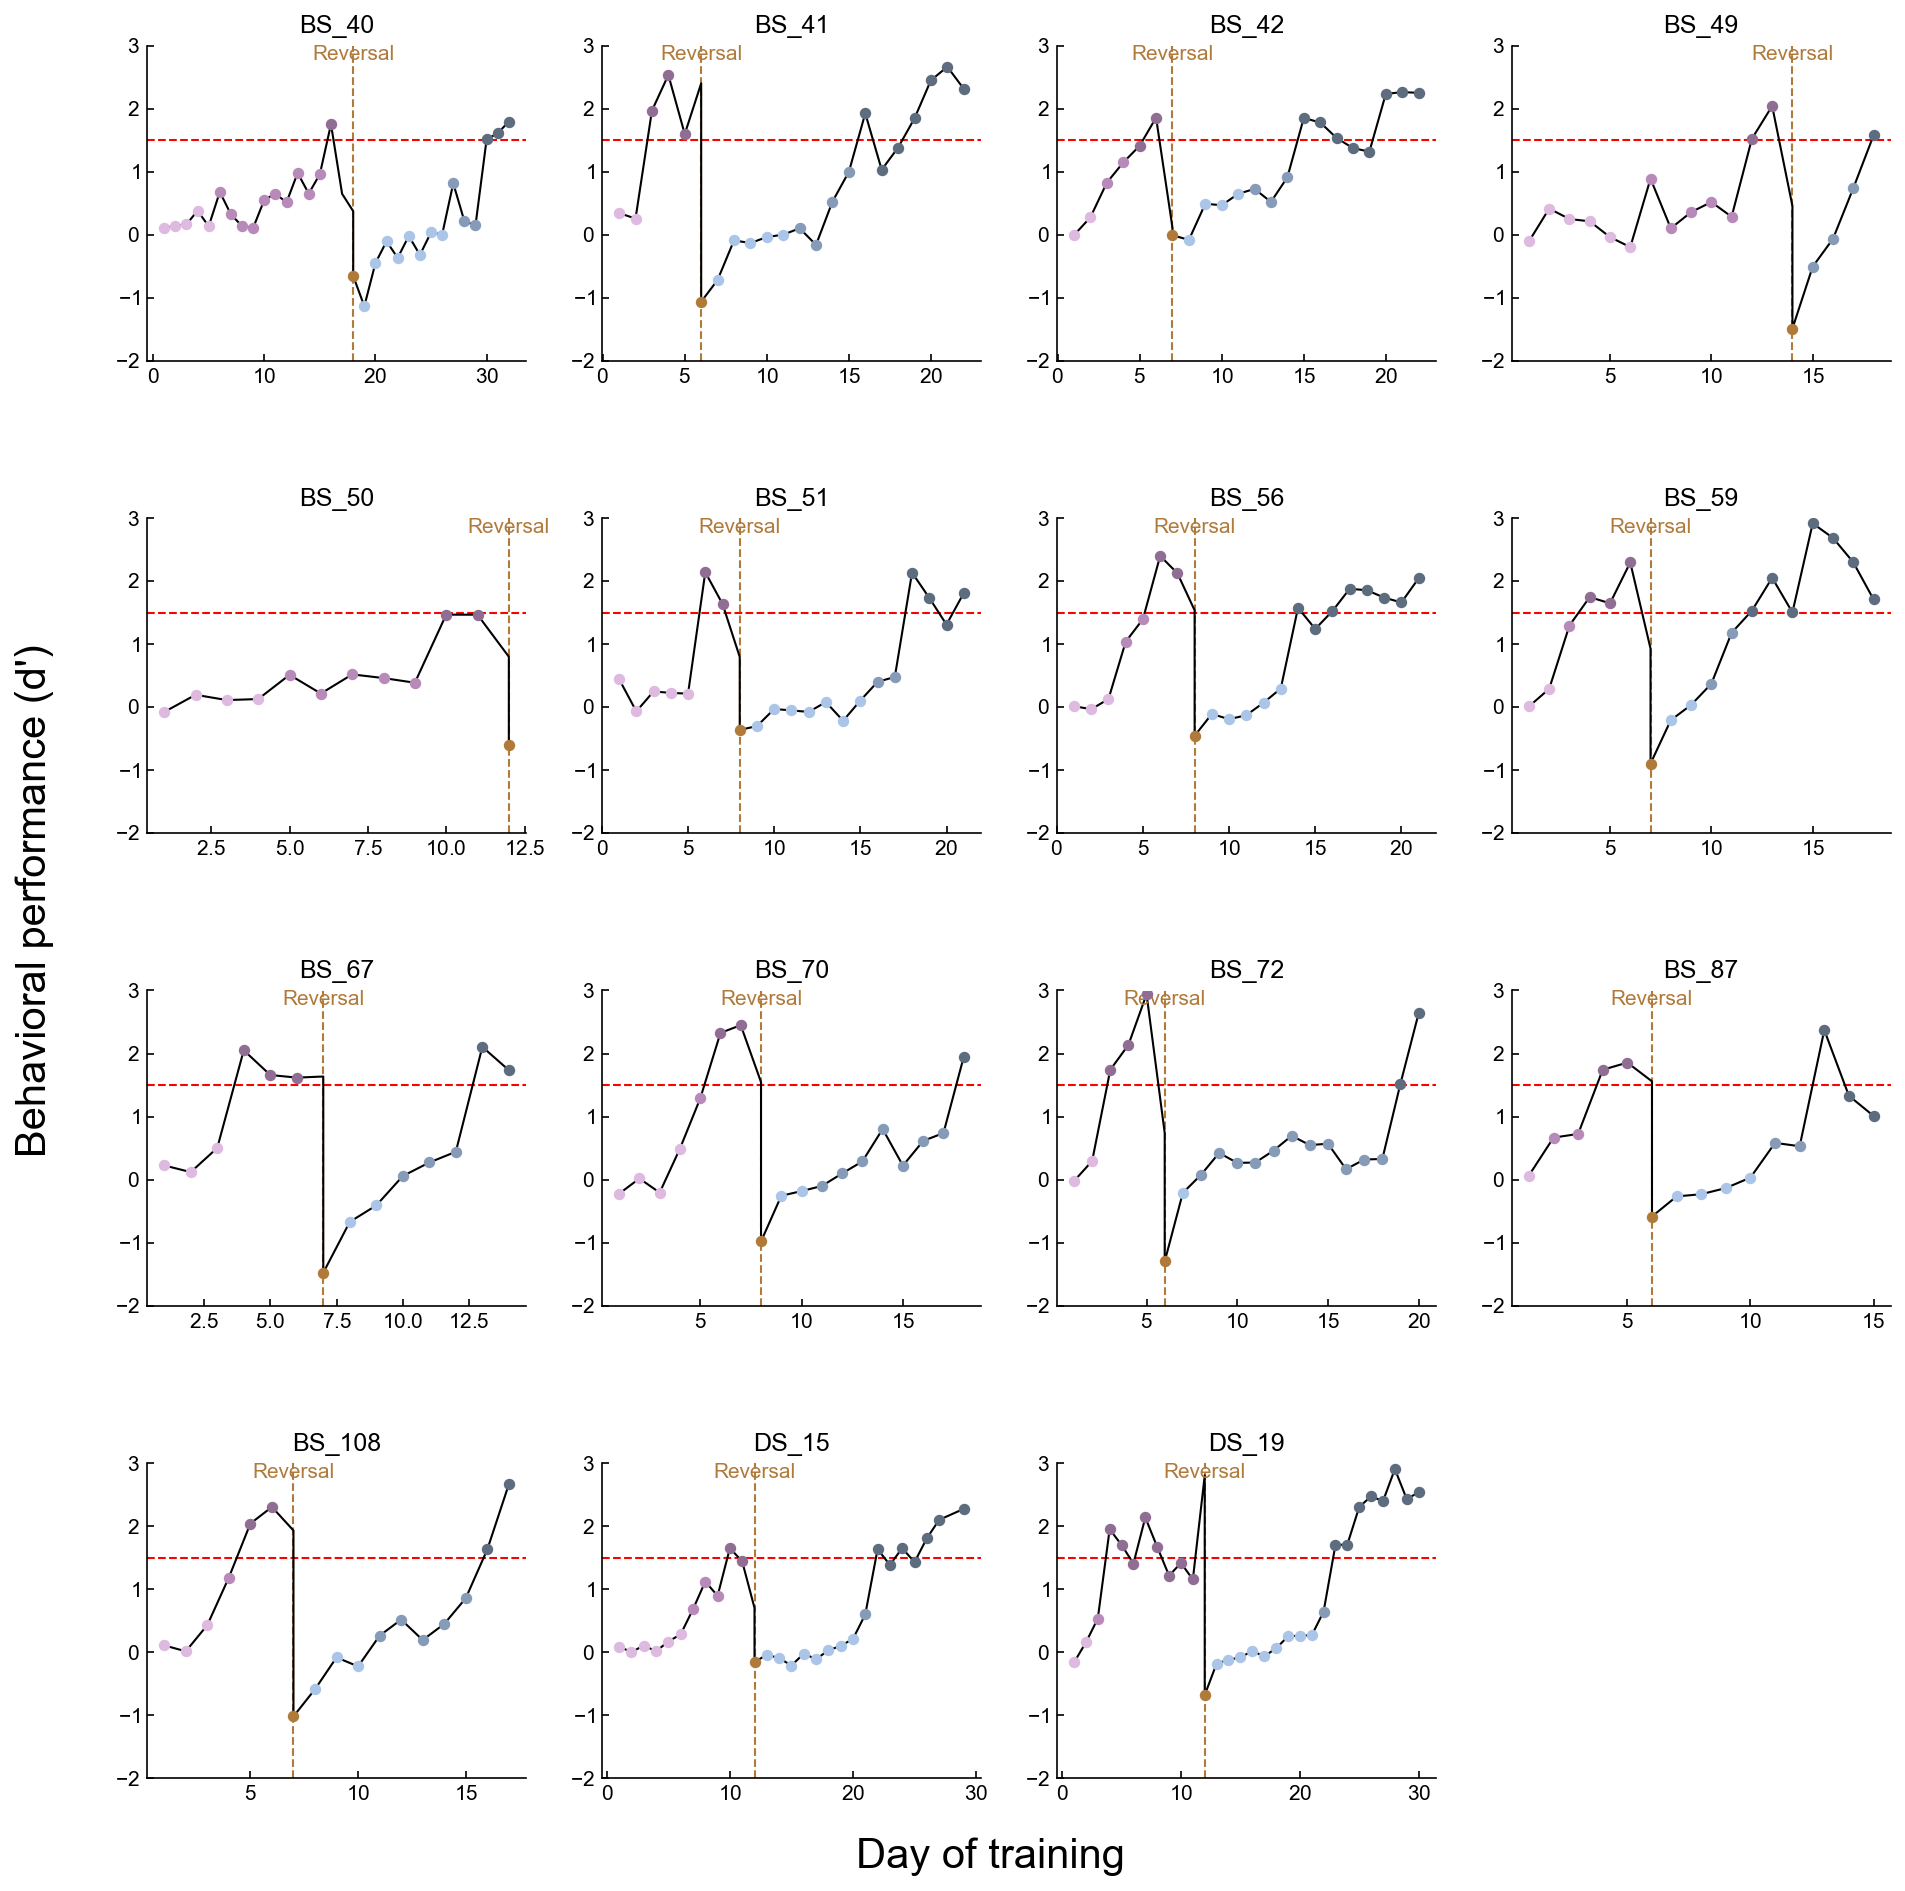

In [4]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)

In [5]:
EnumACSession = []
EnumACClust = []
EnumM2Session = []
EnumM2Clust = []

sessions = os.listdir(act_directory)

numAC = 0
numM2 = 0

for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.task in ['opto nonreversal','opto switch','opto reversal']:
        continue
    if sessionfile.meta.task in ['opto control nonreversal','opto control switch','opto control reversal']:
        continue
    
    if sessionfile.meta.animal not in animals:
        continue
    
    #attribute neurons based on the region
    if sessionfile.meta.region == 'AC':
        numAC += len(sessionfile.clusters.good)
        
        for clust in sessionfile.clusters.good:
            EnumACSession.append(session)
            EnumACClust.append(clust)
            
    elif sessionfile.meta.region == 'M2':
        numM2 += len(sessionfile.clusters.good)
        
        for clust in sessionfile.clusters.good:
            EnumM2Session.append(session)
            EnumM2Clust.append(clust)    
    else:
        pass

        
print('AC       : ' + str(numAC))
print('M2       : ' + str(numM2))

100%|██████████| 536/536 [00:06<00:00, 88.30it/s] 

AC       : 1832
M2       : 1628


In [6]:
EILM2phases = np.full_like(EnumM2Session,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumM2Session)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            EILM2phases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILM2phases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILM2phases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILM2phases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            EILM2phases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            EILM2phases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            EILM2phases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1628/1628 [00:30<00:00, 53.64it/s] 

errors for: []


In [7]:
EILACphases = np.full_like(EnumACSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumACSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            EILACphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILACphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILACphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILACphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            EILACphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            EILACphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            EILACphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1832/1832 [00:33<00:00, 55.26it/s] 

errors for: []


In [8]:
AC_latency_preearly = []
AC_latency_prelate = []
AC_latency_preexpert = []
AC_latency_postearly = []
AC_latency_postlate = []
AC_latency_postexpert = []

M2_latency_preearly = []
M2_latency_prelate = []
M2_latency_preexpert = []
M2_latency_postearly = []
M2_latency_postlate = []
M2_latency_postexpert = []


In [9]:
#For latency analysis, exclude NCR
M2_FRmod_baseline_median = 2.3
AC_FRmod_baseline_median = 3.5

In [10]:
preearly_animals_M2 = []
prelate_animals_M2  = []
preexpert_animals_M2  = []
postearly_animals_M2  = []
postlate_animals_M2  = []
postexpert_animals_M2  = []

FRmod_preearly_M2 = []
FRmod_prelate_M2 = []
FRmod_preexpert_M2 = []
FRmod_postearly_M2 = []
FRmod_postlate_M2 = []
FRmod_postexpert_M2 = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumM2Session,EnumM2Clust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if EILM2phases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
    
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        
    except Exception as e:
        FRmod = np.nan
        
    #if not np.isnan(FRmod):
    if FRmod >= M2_FRmod_baseline_median:
        pstart = sessionfile.responsiveness[clust]['all_trials'].peakstart
        pend = sessionfile.responsiveness[clust]['all_trials'].peakend
        pmid = (pstart+pend)/2

        
    if EILM2phases[idx] == 'pre early':
        FRmod_preearly_M2.append(FRmod)
        M2_latency_preearly.append(pmid)
        preearly_animals_M2.append(sessionfile.meta.animal)   
        
    elif EILM2phases[idx] == 'pre late':
        FRmod_prelate_M2.append(FRmod)
        M2_latency_prelate.append(pmid)
        prelate_animals_M2.append(sessionfile.meta.animal)  
        
    elif EILM2phases[idx] == 'pre expert':
        FRmod_preexpert_M2.append(FRmod)
        M2_latency_preexpert.append(pmid)
        preexpert_animals_M2.append(sessionfile.meta.animal)     
        
    elif EILM2phases[idx] == 'post early':
        FRmod_postearly_M2.append(FRmod)
        M2_latency_postearly.append(pmid)
        postearly_animals_M2.append(sessionfile.meta.animal)   
        
    elif EILM2phases[idx] == 'post late':
        FRmod_postlate_M2.append(FRmod)
        M2_latency_postlate.append(pmid)
        postlate_animals_M2.append(sessionfile.meta.animal)    
        
    elif EILM2phases[idx] == 'post expert':
        FRmod_postexpert_M2.append(FRmod)
        M2_latency_postexpert.append(pmid)
        postexpert_animals_M2.append(sessionfile.meta.animal)

FRmod_preearly_M2 = np.array(FRmod_preearly_M2)
FRmod_prelate_M2 = np.array(FRmod_prelate_M2)
FRmod_preexpert_M2 = np.array(FRmod_preexpert_M2)
FRmod_postearly_M2 = np.array(FRmod_postearly_M2)
FRmod_postlate_M2 = np.array(FRmod_postlate_M2)
FRmod_postexpert_M2 = np.array(FRmod_postexpert_M2)

M2_latency_preearly = np.array(M2_latency_preearly)
M2_latency_prelate = np.array(M2_latency_prelate)
M2_latency_preexpert = np.array(M2_latency_preexpert)
M2_latency_postearly = np.array(M2_latency_postearly)
M2_latency_postlate = np.array(M2_latency_postlate)
M2_latency_postexpert = np.array(M2_latency_postexpert)

1628it [00:30, 53.82it/s] 


In [11]:
preearly_animals_AC = []
prelate_animals_AC  = []
preexpert_animals_AC  = []
postearly_animals_AC  = []
postlate_animals_AC  = []
postexpert_animals_AC  = []

FRmod_preearly_AC = []
FRmod_prelate_AC = []
FRmod_preexpert_AC = []
FRmod_postearly_AC = []
FRmod_postlate_AC = []
FRmod_postexpert_AC = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if EILACphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
    
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    except Exception as e:
        FRmod = np.nan
    
    #if not np.isnan(FRmod):
    if FRmod >= AC_FRmod_baseline_median:
        pstart = sessionfile.responsiveness[clust]['all_trials'].peakstart
        pend = sessionfile.responsiveness[clust]['all_trials'].peakend
        pmid = (pstart+pend)/2
        
        
    if EILACphases[idx] == 'pre early':
        FRmod_preearly_AC.append(FRmod)
        AC_latency_preearly.append(pmid)
        preearly_animals_AC.append(sessionfile.meta.animal)   
        
    elif EILACphases[idx] == 'pre late':
        FRmod_prelate_AC.append(FRmod)
        AC_latency_prelate.append(pmid)
        prelate_animals_AC.append(sessionfile.meta.animal)  
        
    elif EILACphases[idx] == 'pre expert':
        FRmod_preexpert_AC.append(FRmod)
        AC_latency_preexpert.append(pmid)
        preexpert_animals_AC.append(sessionfile.meta.animal)     
        
    elif EILACphases[idx] == 'post early':
        FRmod_postearly_AC.append(FRmod)
        AC_latency_postearly.append(pmid)
        postearly_animals_AC.append(sessionfile.meta.animal)   
        
    elif EILACphases[idx] == 'post late':
        FRmod_postlate_AC.append(FRmod)
        AC_latency_postlate.append(pmid)
        postlate_animals_AC.append(sessionfile.meta.animal)    
        
    elif EILACphases[idx] == 'post expert':
        FRmod_postexpert_AC.append(FRmod)
        AC_latency_postexpert.append(pmid)
        postexpert_animals_AC.append(sessionfile.meta.animal)

FRmod_preearly_AC = np.array(FRmod_preearly_AC)
FRmod_prelate_AC = np.array(FRmod_prelate_AC)
FRmod_preexpert_AC = np.array(FRmod_preexpert_AC)
FRmod_postearly_AC = np.array(FRmod_postearly_AC)
FRmod_postlate_AC = np.array(FRmod_postlate_AC)
FRmod_postexpert_AC = np.array(FRmod_postexpert_AC)

AC_latency_preearly = np.array(AC_latency_preearly)
AC_latency_prelate = np.array(AC_latency_prelate)
AC_latency_preexpert = np.array(AC_latency_preexpert)
AC_latency_postearly = np.array(AC_latency_postearly)
AC_latency_postlate = np.array(AC_latency_postlate)
AC_latency_postexpert = np.array(AC_latency_postexpert)

1832it [00:33, 55.19it/s] 


In [12]:
preearly_animals_M2 = np.unique(preearly_animals_M2)
prelate_animals_M2 = np.unique(prelate_animals_M2)
preexpert_animals_M2 = np.unique(preexpert_animals_M2)
postearly_animals_M2 = np.unique(postearly_animals_M2)
postlate_animals_M2 = np.unique(postlate_animals_M2)
postexpert_animals_M2 = np.unique(postexpert_animals_M2)

preearly_animals_AC = np.unique(preearly_animals_AC)
prelate_animals_AC = np.unique(prelate_animals_AC)
preexpert_animals_AC = np.unique(preexpert_animals_AC)
postearly_animals_AC = np.unique(postearly_animals_AC)
postlate_animals_AC = np.unique(postlate_animals_AC)
postexpert_animals_AC = np.unique(postexpert_animals_AC)

print('M2 Animals')
print(preearly_animals_M2)
print(prelate_animals_M2)
print(preexpert_animals_M2)
print(postearly_animals_M2)
print(postlate_animals_M2)
print(postexpert_animals_M2)
print('AC Animals')
print(preearly_animals_AC)
print(prelate_animals_AC)
print(preexpert_animals_AC)
print(postearly_animals_AC)
print(postlate_animals_AC)
print(postexpert_animals_AC)

M2 Animals
['BS_49' 'BS_50']
['BS_40' 'BS_49' 'BS_50' 'BS_70']
['BS_108' 'BS_50' 'BS_70' 'BS_72' 'BS_87']
['BS_108' 'BS_40' 'BS_41' 'BS_42' 'BS_70' 'BS_72' 'BS_87']
['BS_108' 'BS_41' 'BS_42' 'BS_49' 'BS_67' 'BS_70' 'BS_72' 'BS_87']
['BS_41' 'BS_42' 'BS_51' 'BS_56' 'BS_59' 'BS_67' 'BS_87']
AC Animals
['BS_49' 'BS_50']
['BS_40' 'BS_49' 'BS_50' 'BS_70']
['BS_108' 'BS_40' 'BS_49' 'BS_72' 'BS_87' 'DS_15' 'DS_19']
['BS_108' 'BS_40' 'BS_41' 'BS_42' 'BS_70' 'BS_72' 'BS_87']
['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_67' 'BS_70' 'BS_72' 'BS_87']
['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_51' 'BS_56' 'BS_67' 'BS_70' 'BS_87'
 'DS_15' 'DS_19']


In [13]:
AC_sessions = np.unique(EnumACSession)
M2_sessions = np.unique(EnumM2Session)

AC_sessions = list(AC_sessions)
M2_sessions = list(M2_sessions)

In [14]:
ACphases = np.full_like(AC_sessions,np.nan)
error_animals = []

AC_switch = []
AC_preearly = []
AC_prelate = []
AC_preexpert = []
AC_postearly = []
AC_postlate = []
AC_postexpert = []

for idx,session in enumerate(tqdm(AC_sessions)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            ACphases[idx] = 'switch'
            AC_switch.append(session)

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            ACphases[idx] = 'pre early'
            AC_preearly.append(session)
            
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            ACphases[idx] = 'pre late'
            AC_prelate.append(session)
            
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            ACphases[idx] = 'pre expert'
            AC_preexpert.append(session)

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            ACphases[idx] = 'post early'
            AC_postearly.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            ACphases[idx] = 'post late'
            AC_postlate.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            ACphases[idx] = 'post expert'
            AC_postexpert.append(session)
            
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 132/132 [00:01<00:00, 91.61it/s] 

errors for: []


In [15]:
M2phases = np.full_like(M2_sessions,np.nan)
error_animals = []

M2_switch = []
M2_preearly = []
M2_prelate = []
M2_preexpert = []
M2_postearly = []
M2_postlate = []
M2_postexpert = []

for idx,session in enumerate(tqdm(M2_sessions)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            M2phases[idx] = 'switch'
            M2_switch.append(session)

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            M2phases[idx] = 'pre early'
            M2_preearly.append(session)
            
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            M2phases[idx] = 'pre late'
            M2_prelate.append(session)
            
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            M2phases[idx] = 'pre expert'
            M2_preexpert.append(session)

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            M2phases[idx] = 'post early'
            M2_postearly.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            M2phases[idx] = 'post late'
            M2_postlate.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            M2phases[idx] = 'post expert'
            M2_postexpert.append(session)
            
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))


100%|██████████| 103/103 [00:01<00:00, 81.74it/s]

errors for: []


# Load Decoding Data AC

In [16]:
stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
passivedecodingfilename = 'D:\\stimdecoding_25s_passive.csv'
choicedecodingfilename = 'D:\\choicedecoding.csv'

In [17]:
stim_25s_df = pd.read_csv(stim25sdecodingfilename)
passive_df = pd.read_csv(passivedecodingfilename)
choice_df = pd.read_csv(choicedecodingfilename)
dec_df = pd.concat([stim_25s_df,choice_df,passive_df])

def getDataPoint(df,session,clust,categories,column):
    df = df[df['session']==session]
    df = df[df['clust']==clust]
    df = df[df['categories']==categories]
    val = list(df[column])
    if len(val) == 1:
        return val[0]
    elif len(val) <= 0:
        return np.nan
    else:
        raise Exception('Incorrent length. Duplicate values')

In [22]:
AC_ChoiceMod_preearly = []
AC_ChoiceMod_prelate = []
AC_ChoiceMod_preexpert = []
AC_ChoiceMod_postearly = []
AC_ChoiceMod_postlate = []
AC_ChoiceMod_postexpert = []
AC_ChoiceMod_switch = []

AC_ChoiceMod_preearly = []
AC_ChoiceMod_prelate = []
AC_ChoiceMod_preexpert = []
AC_ChoiceMod_postearly = []
AC_ChoiceMod_postlate = []
AC_ChoiceMod_postexpert = []
AC_ChoiceMod_switch = []

AC_Stim_Dec_preearly = []
AC_Stim_Dec_prelate = []
AC_Stim_Dec_preexpert = []
AC_Stim_Dec_postearly = []
AC_Stim_Dec_postlate = []
AC_Stim_Dec_postexpert = []

AC_Choice_Dec_preearly = []
AC_Choice_Dec_prelate = []
AC_Choice_Dec_preexpert = []
AC_Choice_Dec_postearly = []
AC_Choice_Dec_postlate = []
AC_Choice_Dec_postexpert = []

AC_Control_Stim_Dec_preearly = []
AC_Control_Stim_Dec_prelate = []
AC_Control_Stim_Dec_preexpert = []
AC_Control_Stim_Dec_postearly = []
AC_Control_Stim_Dec_postlate = []
AC_Control_Stim_Dec_postexpert = []

AC_Control_Choice_Dec_preearly = []
AC_Control_Choice_Dec_prelate = []
AC_Control_Choice_Dec_preexpert = []
AC_Control_Choice_Dec_postearly = []
AC_Control_Choice_Dec_postlate = []
AC_Control_Choice_Dec_postexpert = []

EnumSession = EnumACSession
EnumClust = EnumACClust
EILphases = EILACphases
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        ChoiceMod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation_choice
    except Exception as e:
        ChoiceMod = np.nan
        print(f"{session} - choice FRmod: {e}")
        
    stim_acc = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    choice_acc = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    stim_acc_control = getDataPoint(dec_df,session,clust,'stimulus','synthetic_control_weighted_accuracy')
    choice_acc_control = getDataPoint(dec_df,session,clust,'response','synthetic_control_weighted_accuracy')
    

    if getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control') > 0.05:
        stim_acc = np.nan
    if getDataPoint(dec_df,session,clust,'response','pval_synthetic_control') > 0.05:
        choice_acc = np.nan
        
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
    
    if EILphases[idx] == 'pre early':
        AC_ChoiceMod_preearly.append(ChoiceMod)
        AC_Stim_Dec_preearly.append(stim_acc)
        AC_Choice_Dec_preearly.append(choice_acc)
        AC_Control_Stim_Dec_preearly.append(stim_acc_control)
        AC_Control_Choice_Dec_preearly.append(choice_acc_control)
    elif EILphases[idx] == 'pre late':
        AC_ChoiceMod_prelate.append(ChoiceMod)
        AC_Stim_Dec_prelate.append(stim_acc)
        AC_Choice_Dec_prelate.append(choice_acc)
        AC_Control_Stim_Dec_prelate.append(stim_acc_control)
        AC_Control_Choice_Dec_prelate.append(choice_acc_control)
    elif EILphases[idx] == 'pre expert':
        AC_ChoiceMod_preexpert.append(ChoiceMod)
        AC_Stim_Dec_preexpert.append(stim_acc)
        AC_Choice_Dec_preexpert.append(choice_acc)
        AC_Control_Stim_Dec_preexpert.append(stim_acc_control)
        AC_Control_Choice_Dec_preexpert.append(choice_acc_control)
    elif EILphases[idx] == 'post early':
        AC_ChoiceMod_postearly.append(ChoiceMod)
        AC_Stim_Dec_postearly.append(stim_acc)
        AC_Choice_Dec_postearly.append(choice_acc)
        AC_Control_Stim_Dec_postearly.append(stim_acc_control)
        AC_Control_Choice_Dec_postearly.append(choice_acc_control)
    elif EILphases[idx] == 'post late':
        AC_ChoiceMod_postlate.append(ChoiceMod)
        AC_Stim_Dec_postlate.append(stim_acc)
        AC_Choice_Dec_postlate.append(choice_acc)
        AC_Control_Stim_Dec_postlate.append(stim_acc_control)
        AC_Control_Choice_Dec_postlate.append(choice_acc_control)
    elif EILphases[idx] == 'post expert':
        AC_ChoiceMod_postexpert.append(ChoiceMod)
        AC_Stim_Dec_postexpert.append(stim_acc)
        AC_Choice_Dec_postexpert.append(choice_acc)
        AC_Control_Stim_Dec_postexpert.append(stim_acc_control)
        AC_Control_Choice_Dec_postexpert.append(choice_acc_control)
        

AC_ChoiceMod_preearly = np.array(AC_ChoiceMod_preearly)
AC_ChoiceMod_prelate = np.array(AC_ChoiceMod_prelate)
AC_ChoiceMod_preexpert = np.array(AC_ChoiceMod_preexpert)
AC_ChoiceMod_postearly = np.array(AC_ChoiceMod_postearly)
AC_ChoiceMod_postlate = np.array(AC_ChoiceMod_postlate)
AC_ChoiceMod_postexpert = np.array(AC_ChoiceMod_postexpert)
        
AC_Stim_Dec_preearly = np.array(AC_Stim_Dec_preearly)
AC_Stim_Dec_prelate = np.array(AC_Stim_Dec_prelate)
AC_Stim_Dec_preexpert = np.array(AC_Stim_Dec_preexpert)
AC_Stim_Dec_postearly = np.array(AC_Stim_Dec_postearly)
AC_Stim_Dec_postlate = np.array(AC_Stim_Dec_postlate)
AC_Stim_Dec_postexpert = np.array(AC_Stim_Dec_postexpert)

AC_Choice_Dec_preearly = np.array(AC_Choice_Dec_preearly)
AC_Choice_Dec_prelate = np.array(AC_Choice_Dec_prelate)
AC_Choice_Dec_preexpert = np.array(AC_Choice_Dec_preexpert)
AC_Choice_Dec_postearly = np.array(AC_Choice_Dec_postearly)
AC_Choice_Dec_postlate = np.array(AC_Choice_Dec_postlate)
AC_Choice_Dec_postexpert = np.array(AC_Choice_Dec_postexpert)

AC_Control_Stim_Dec_preearly = np.array(AC_Control_Stim_Dec_preearly)
AC_Control_Stim_Dec_prelate = np.array(AC_Control_Stim_Dec_prelate)
AC_Control_Stim_Dec_preexpert = np.array(AC_Control_Stim_Dec_preexpert)
AC_Control_Stim_Dec_postearly = np.array(AC_Control_Stim_Dec_postearly)
AC_Control_Stim_Dec_postlate = np.array(AC_Control_Stim_Dec_postlate)
AC_Control_Stim_Dec_postexpert = np.array(AC_Control_Stim_Dec_postexpert)

AC_Control_Choice_Dec_preearly = np.array(AC_Control_Choice_Dec_preearly)
AC_Control_Choice_Dec_prelate = np.array(AC_Control_Choice_Dec_prelate)
AC_Control_Choice_Dec_preexpert = np.array(AC_Control_Choice_Dec_preexpert)
AC_Control_Choice_Dec_postearly = np.array(AC_Control_Choice_Dec_postearly)
AC_Control_Choice_Dec_postlate = np.array(AC_Control_Choice_Dec_postlate)
AC_Control_Choice_Dec_postexpert = np.array(AC_Control_Choice_Dec_postexpert)

1832it [00:45, 40.28it/s]


# Load Decoding Data M2

In [35]:
stim25sdecodingfilename = 'D:\\stimdecoding_25s_M2.csv'
passivedecodingfilename = 'D:\\stimdecoding_25s_passive.csv'
choicedecodingfilename = 'D:\\choicedecoding_25s_M2.csv'

stim_25s_df = pd.read_csv(stim25sdecodingfilename)
passive_df = pd.read_csv(passivedecodingfilename)
choice_df = pd.read_csv(choicedecodingfilename)
dec_df = pd.concat([stim_25s_df,choice_df,passive_df])

In [36]:
M2_ChoiceMod_preearly = []
M2_ChoiceMod_prelate = []
M2_ChoiceMod_preexpert = []
M2_ChoiceMod_postearly = []
M2_ChoiceMod_postlate = []
M2_ChoiceMod_postexpert = []
M2_ChoiceMod_switch = []

M2_Stim_Dec_preearly = []
M2_Stim_Dec_prelate = []
M2_Stim_Dec_preexpert = []
M2_Stim_Dec_postearly = []
M2_Stim_Dec_postlate = []
M2_Stim_Dec_postexpert = []

M2_Choice_Dec_preearly = []
M2_Choice_Dec_prelate = []
M2_Choice_Dec_preexpert = []
M2_Choice_Dec_postearly = []
M2_Choice_Dec_postlate = []
M2_Choice_Dec_postexpert = []

M2_Control_Stim_Dec_preearly = []
M2_Control_Stim_Dec_prelate = []
M2_Control_Stim_Dec_preexpert = []
M2_Control_Stim_Dec_postearly = []
M2_Control_Stim_Dec_postlate = []
M2_Control_Stim_Dec_postexpert = []

M2_Control_Choice_Dec_preearly = []
M2_Control_Choice_Dec_prelate = []
M2_Control_Choice_Dec_preexpert = []
M2_Control_Choice_Dec_postearly = []
M2_Control_Choice_Dec_postlate = []
M2_Control_Choice_Dec_postexpert = []

EnumSession = EnumM2Session
EnumClust = EnumM2Clust
EILphases = EILM2phases
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        ChoiceMod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation_choice
    except Exception as e:
        ChoiceMod = np.nan
        print(f"{session} - choice FRmod: {e}")
        
    stim_acc = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    choice_acc = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    stim_acc_control = getDataPoint(dec_df,session,clust,'stimulus','synthetic_control_weighted_accuracy')
    choice_acc_control = getDataPoint(dec_df,session,clust,'response','synthetic_control_weighted_accuracy')
    

    if getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control') > 0.05:
        stim_acc = np.nan
    if getDataPoint(dec_df,session,clust,'response','pval_synthetic_control') > 0.05:
        choice_acc = np.nan
        
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
    
    if EILphases[idx] == 'pre early':
        M2_ChoiceMod_preearly.append(ChoiceMod)
        M2_Stim_Dec_preearly.append(stim_acc)
        M2_Choice_Dec_preearly.append(choice_acc)
        M2_Control_Stim_Dec_preearly.append(stim_acc_control)
        M2_Control_Choice_Dec_preearly.append(choice_acc_control)
    elif EILphases[idx] == 'pre late':
        M2_ChoiceMod_prelate.append(ChoiceMod)
        M2_Stim_Dec_prelate.append(stim_acc)
        M2_Choice_Dec_prelate.append(choice_acc)
        M2_Control_Stim_Dec_prelate.append(stim_acc_control)
        M2_Control_Choice_Dec_prelate.append(choice_acc_control)
    elif EILphases[idx] == 'pre expert':
        M2_ChoiceMod_preexpert.append(ChoiceMod)
        M2_Stim_Dec_preexpert.append(stim_acc)
        M2_Choice_Dec_preexpert.append(choice_acc)
        M2_Control_Stim_Dec_preexpert.append(stim_acc_control)
        M2_Control_Choice_Dec_preexpert.append(choice_acc_control)
    elif EILphases[idx] == 'post early':
        M2_ChoiceMod_postearly.append(ChoiceMod)
        M2_Stim_Dec_postearly.append(stim_acc)
        M2_Choice_Dec_postearly.append(choice_acc)
        M2_Control_Stim_Dec_postearly.append(stim_acc_control)
        M2_Control_Choice_Dec_postearly.append(choice_acc_control)
    elif EILphases[idx] == 'post late':
        M2_ChoiceMod_postlate.append(ChoiceMod)
        M2_Stim_Dec_postlate.append(stim_acc)
        M2_Choice_Dec_postlate.append(choice_acc)
        M2_Control_Stim_Dec_postlate.append(stim_acc_control)
        M2_Control_Choice_Dec_postlate.append(choice_acc_control)
    elif EILphases[idx] == 'post expert':
        M2_ChoiceMod_postexpert.append(ChoiceMod)
        M2_Stim_Dec_postexpert.append(stim_acc)
        M2_Choice_Dec_postexpert.append(choice_acc)
        M2_Control_Stim_Dec_postexpert.append(stim_acc_control)
        M2_Control_Choice_Dec_postexpert.append(choice_acc_control)
        

M2_ChoiceMod_preearly = np.array(M2_ChoiceMod_preearly)
M2_ChoiceMod_prelate = np.array(M2_ChoiceMod_prelate)
M2_ChoiceMod_preexpert = np.array(M2_ChoiceMod_preexpert)
M2_ChoiceMod_postearly = np.array(M2_ChoiceMod_postearly)
M2_ChoiceMod_postlate = np.array(M2_ChoiceMod_postlate)
M2_ChoiceMod_postexpert = np.array(M2_ChoiceMod_postexpert)
        
M2_Stim_Dec_preearly = np.array(M2_Stim_Dec_preearly)
M2_Stim_Dec_prelate = np.array(M2_Stim_Dec_prelate)
M2_Stim_Dec_preexpert = np.array(M2_Stim_Dec_preexpert)
M2_Stim_Dec_postearly = np.array(M2_Stim_Dec_postearly)
M2_Stim_Dec_postlate = np.array(M2_Stim_Dec_postlate)
M2_Stim_Dec_postexpert = np.array(M2_Stim_Dec_postexpert)

M2_Choice_Dec_preearly = np.array(M2_Choice_Dec_preearly)
M2_Choice_Dec_prelate = np.array(M2_Choice_Dec_prelate)
M2_Choice_Dec_preexpert = np.array(M2_Choice_Dec_preexpert)
M2_Choice_Dec_postearly = np.array(M2_Choice_Dec_postearly)
M2_Choice_Dec_postlate = np.array(M2_Choice_Dec_postlate)
M2_Choice_Dec_postexpert = np.array(M2_Choice_Dec_postexpert)

M2_Control_Stim_Dec_preearly = np.array(M2_Control_Stim_Dec_preearly)
M2_Control_Stim_Dec_prelate = np.array(M2_Control_Stim_Dec_prelate)
M2_Control_Stim_Dec_preexpert = np.array(M2_Control_Stim_Dec_preexpert)
M2_Control_Stim_Dec_postearly = np.array(M2_Control_Stim_Dec_postearly)
M2_Control_Stim_Dec_postlate = np.array(M2_Control_Stim_Dec_postlate)
M2_Control_Stim_Dec_postexpert = np.array(M2_Control_Stim_Dec_postexpert)

M2_Control_Choice_Dec_preearly = np.array(M2_Control_Choice_Dec_preearly)
M2_Control_Choice_Dec_prelate = np.array(M2_Control_Choice_Dec_prelate)
M2_Control_Choice_Dec_preexpert = np.array(M2_Control_Choice_Dec_preexpert)
M2_Control_Choice_Dec_postearly = np.array(M2_Control_Choice_Dec_postearly)
M2_Control_Choice_Dec_postlate = np.array(M2_Control_Choice_Dec_postlate)
M2_Control_Choice_Dec_postexpert = np.array(M2_Control_Choice_Dec_postexpert)

1628it [00:41, 38.97it/s]


In [37]:
M2_Stim_Dec_preearly

array([0.55545607, 0.54624455,        nan, 0.50724708, 0.40128429,
       0.46331877,        nan,        nan, 0.51295962, 0.49349844,
       0.5196726 , 0.46342964,        nan, 0.46927051,        nan,
       0.52340068, 0.5507612 , 0.55289143, 0.48113955, 0.5536241 ,
       0.56393321, 0.53135769, 0.59629842, 0.55165188, 0.51028878,
              nan, 0.47714297, 0.43031152, 0.54398217, 0.51033676,
              nan, 0.48294328, 0.51695306, 0.48026584, 0.56946851,
       0.50338327, 0.57132189, 0.48534903, 0.50488475,        nan,
       0.46870455, 0.46926867,        nan, 0.57887018, 0.56049656,
       0.418911  , 0.58030291, 0.59843411, 0.51961538, 0.50788462,
       0.39735577, 0.43375   , 0.53713141,        nan,        nan,
       0.47121795,        nan,        nan,        nan,        nan,
       0.58105769, 0.43168269,        nan, 0.61173077, 0.54945513,
       0.52304487, 0.55705159, 0.6032531 , 0.42275889, 0.44310374,
              nan, 0.63866827, 0.52790435, 0.51524166, 0.62564

# Fig

## Stimulus

meta NOT subset; don't know how to subset; dropped


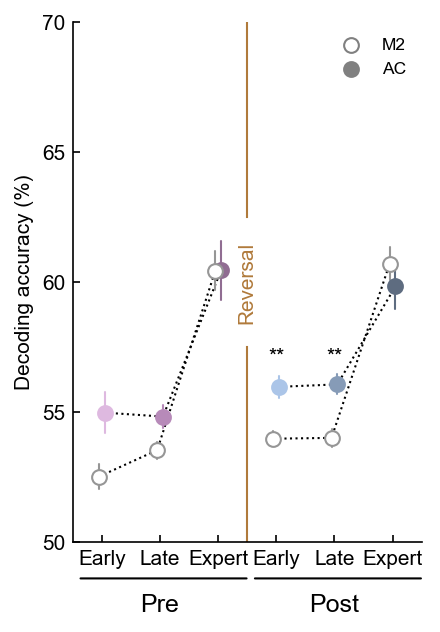

In [73]:
#Firing rate modulation graphs
size=5
numCon = 6

labels = ['Early','Late','Expert','Early','Late','Expert']
offset_distance = 0.05

fig, ax = plt.subplots(figsize=(3,4.5)) #5/3 with height of 4.5

data = [AC_Stim_Dec_preearly,AC_Stim_Dec_prelate,AC_Stim_Dec_preexpert,AC_Stim_Dec_postearly,AC_Stim_Dec_postlate,AC_Stim_Dec_postexpert]
data = [ilep.rmnan(d) for d in data]
#Plot summary
colmaxes = [np.nan]*6
for idx,column in enumerate(data):
    eye_color = PHASE_COLORS[idx]
    border_color=eye_color
    summary_size=50
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes[idx] = Q3
    
    ax.scatter([idx+offset_distance], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+offset_distance, idx+offset_distance], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data]
plt.plot(np.linspace(0,2,3)+offset_distance,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)+offset_distance,medians[3:6],color='k',linestyle=':',lw=1)
    
######################################################################################################################################################
passive_data = [M2_Stim_Dec_preearly,M2_Stim_Dec_prelate,M2_Stim_Dec_preexpert,M2_Stim_Dec_postearly,M2_Stim_Dec_postlate,M2_Stim_Dec_postexpert]
passive_data = [ilep.rmnan(d) for d in passive_data]

#Plot summary
passive_colmaxes = [np.nan]*6
for idx,column in enumerate(passive_data):
    border_color=GOOD_GREY
    eye_color='white'

    summary_size=50
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    passive_colmaxes[idx] = Q3
    
    ax.scatter([idx-offset_distance], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10,marker='o')
    ax.plot([idx-offset_distance, idx-offset_distance], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in passive_data]
plt.plot(np.linspace(0,2,3)-offset_distance,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)-offset_distance,medians[3:6],color='k',linestyle=':',lw=1)


ax.set_ylim([0.5,0.7])
ax.set_yticks([0.5,0.55,0.6,0.65,0.7])
ax.set_yticklabels([50,55,60,65,70])
ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim(ax.get_xlim())
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)


ax.scatter([],[],ec='grey',fc='white',s=summary_size,lw=summary_width,zorder=10,marker='o',label='M2')
ax.scatter([],[],ec='grey',fc='grey',s=summary_size,lw=summary_width,zorder=10,marker='o',label='AC')
lgd = ax.legend(frameon=False)#,loc=(0.6,0.1))




size = 0.025
rev = 2.5
center = np.mean(ax.get_ylim())
ax.text(rev,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
ax.plot([rev,rev],[ax.get_ylim()[0],center-size],color=SWITCH_COLOR,lw=1,linestyle='-')
ax.plot([rev,rev],[center+size,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')


    

#statistics
# ax.text(2,0.625,str('****'),verticalalignment='top',horizontalalignment='center')
ax.text(3,0.575,str('**'),verticalalignment='top',horizontalalignment='center')
ax.text(4,0.575,str('**'),verticalalignment='top',horizontalalignment='center')
# ax.text(5,0.615,str('****'),verticalalignment='top',horizontalalignment='center')



xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+0.005
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.01, -0.07), xycoords='axes fraction', xytext=(0.51, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.51, -0.07), xycoords='axes fraction', xytext=(1.01, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\PHRC_Dual\\Decoding\\AC vs M2 stimulus.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')

## Choice

meta NOT subset; don't know how to subset; dropped


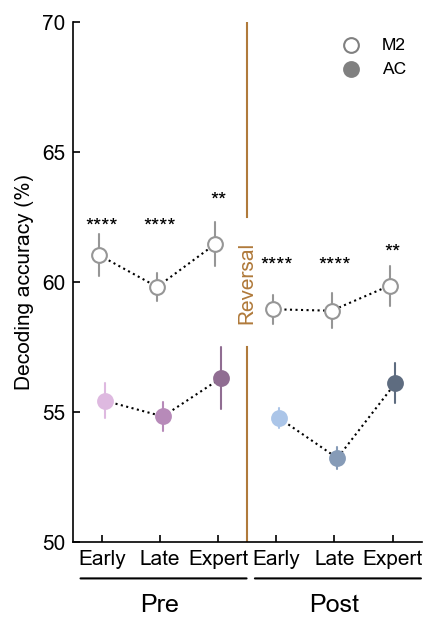

In [84]:
#Firing rate modulation graphs
size=5
numCon = 6

labels = ['Early','Late','Expert','Early','Late','Expert']
offset_distance = 0.05

fig, ax = plt.subplots(figsize=(3,4.5)) #5/3 with height of 4.5

data = [AC_Choice_Dec_preearly,AC_Choice_Dec_prelate,AC_Choice_Dec_preexpert,AC_Choice_Dec_postearly,AC_Choice_Dec_postlate,AC_Choice_Dec_postexpert]
data = [ilep.rmnan(d) for d in data]
#Plot summary
colmaxes = [np.nan]*6
for idx,column in enumerate(data):
    eye_color = PHASE_COLORS[idx]
    border_color=eye_color
    summary_size=50
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes[idx] = Q3
    
    ax.scatter([idx+offset_distance], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+offset_distance, idx+offset_distance], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data]
plt.plot(np.linspace(0,2,3)+offset_distance,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)+offset_distance,medians[3:6],color='k',linestyle=':',lw=1)
    
######################################################################################################################################################
passive_data = [M2_Choice_Dec_preearly,M2_Choice_Dec_prelate,M2_Choice_Dec_preexpert,M2_Choice_Dec_postearly,M2_Choice_Dec_postlate,M2_Choice_Dec_postexpert]
passive_data = [ilep.rmnan(d) for d in passive_data]

#Plot summary
passive_colmaxes = [np.nan]*6
for idx,column in enumerate(passive_data):
    border_color=GOOD_GREY
    eye_color='white'

    summary_size=50
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    passive_colmaxes[idx] = Q3
    
    ax.scatter([idx-offset_distance], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10,marker='o')
    ax.plot([idx-offset_distance, idx-offset_distance], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in passive_data]
plt.plot(np.linspace(0,2,3)-offset_distance,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)-offset_distance,medians[3:6],color='k',linestyle=':',lw=1)


ax.set_ylim([0.5,0.7])
ax.set_yticks([0.5,0.55,0.6,0.65,0.7])
ax.set_yticklabels([50,55,60,65,70])
ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim(ax.get_xlim())
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)


ax.scatter([],[],ec='grey',fc='white',s=summary_size,lw=summary_width,zorder=10,marker='o',label='M2')
ax.scatter([],[],ec='grey',fc='grey',s=summary_size,lw=summary_width,zorder=10,marker='o',label='AC')
lgd = ax.legend(frameon=False)#,loc=(0.6,0.1))




size = 0.025
rev = 2.5
center = np.mean(ax.get_ylim())
ax.text(rev,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
ax.plot([rev,rev],[ax.get_ylim()[0],center-size],color=SWITCH_COLOR,lw=1,linestyle='-')
ax.plot([rev,rev],[center+size,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')


    

#statistics
ax.text(0,0.625,str('****'),verticalalignment='top',horizontalalignment='center')
ax.text(1,0.625,str('****'),verticalalignment='top',horizontalalignment='center')
ax.text(2,0.635,str('**'),verticalalignment='top',horizontalalignment='center')

ax.text(3,0.61,str('****'),verticalalignment='top',horizontalalignment='center')
ax.text(4,0.61,str('****'),verticalalignment='top',horizontalalignment='center')
ax.text(5,0.615,str('**'),verticalalignment='top',horizontalalignment='center')



xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+0.005
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.01, -0.07), xycoords='axes fraction', xytext=(0.51, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.51, -0.07), xycoords='axes fraction', xytext=(1.01, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\PHRC_Dual\\Decoding\\AC vs M2 choice.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')

# Stats AC and M2

In [48]:
AC_data_dec = SimpleNamespace()
AC_data_dec.preearly = AC_Stim_Dec_preearly
AC_data_dec.prelate = AC_Stim_Dec_prelate
AC_data_dec.preexpert = AC_Stim_Dec_preexpert
AC_data_dec.postearly = AC_Stim_Dec_postearly
AC_data_dec.postlate = AC_Stim_Dec_postlate
AC_data_dec.postexpert = AC_Stim_Dec_postexpert

M2_data_dec = SimpleNamespace()
M2_data_dec.preearly = M2_Stim_Dec_preearly
M2_data_dec.prelate = M2_Stim_Dec_prelate
M2_data_dec.preexpert = M2_Stim_Dec_preexpert
M2_data_dec.postearly = M2_Stim_Dec_postearly
M2_data_dec.postlate = M2_Stim_Dec_postlate
M2_data_dec.postexpert = M2_Stim_Dec_postexpert

ilep.nonparametricIndependentStatsCompareToOther(AC_data_dec,M2_data_dec)
pass

            Source         SS      DF        MS          F         p-unc  \
0            phase   1.413961     5.0  0.282792  59.034227  1.044827e-57   
1          context   0.091763     1.0  0.091763  19.155866  1.262816e-05   
2  phase * context   0.066113     5.0  0.013223   2.760263  1.716253e-02   
3         Residual  10.217733  2133.0  0.004790        NaN           NaN   

        np2  
0  0.121561  
1  0.008901  
2  0.006429  
3       NaN  

          phase  A  B     p-unc    p-corr    hedges
16   post-early  A  B  0.003290  0.009871  0.314085
17  post-expert  A  B  0.070676  0.084811 -0.094172
18    post-late  A  B  0.001076  0.006458  0.369270
19    pre-early  A  B  0.055424  0.083136  0.352571
20   pre-expert  A  B  0.732080  0.732080  0.002295
21     pre-late  A  B  0.036701  0.073401  0.254547
key preearly has 113 and 125 non-nan elements
key prelate has 158 and 207 non-nan elements
key preexpert has 74 and 140 non-nan elements
key postearly has 294 and 282 non-nan elements


In [49]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

In [ ]:
post early**
post late**



In [40]:
AC_data_dec = SimpleNamespace()
AC_data_dec.preearly = AC_Choice_Dec_preearly
AC_data_dec.prelate = AC_Choice_Dec_prelate
AC_data_dec.preexpert = AC_Choice_Dec_preexpert
AC_data_dec.postearly = AC_Choice_Dec_postearly
AC_data_dec.postlate = AC_Choice_Dec_postlate
AC_data_dec.postexpert = AC_Choice_Dec_postexpert

M2_data_dec = SimpleNamespace()
M2_data_dec.preearly = M2_Choice_Dec_preearly
M2_data_dec.prelate = M2_Choice_Dec_prelate
M2_data_dec.preexpert = M2_Choice_Dec_preexpert
M2_data_dec.postearly = M2_Choice_Dec_postearly
M2_data_dec.postlate = M2_Choice_Dec_postlate
M2_data_dec.postexpert = M2_Choice_Dec_postexpert

ilep.nonparametricIndependentStatsCompareToOther(AC_data_dec,M2_data_dec)
pass

            Source         SS      DF        MS           F         p-unc  \
0            phase   0.154835     5.0  0.030967    4.392743  5.566003e-04   
1          context   1.102830     1.0  1.102830  156.438850  1.293581e-34   
2  phase * context   0.024044     5.0  0.004809    0.682126  6.370046e-01   
3         Residual  14.092132  1999.0  0.007050         NaN           NaN   

        np2  
0  0.010868  
1  0.072579  
2  0.001703  
3       NaN  

          phase  A  B         p-unc        p-corr    hedges
16   post-early  A  B  4.297288e-08  8.594576e-08 -0.502262
17  post-expert  A  B  1.731461e-03  1.731461e-03 -0.390620
18    post-late  A  B  1.816323e-13  1.089794e-12 -0.736407
19    pre-early  A  B  5.206671e-07  7.810006e-07 -0.661997
20   pre-expert  A  B  9.201419e-04  1.104170e-03 -0.525938
21     pre-late  A  B  1.837323e-09  5.511969e-09 -0.677833
key preearly has 102 and 139 non-nan elements
key prelate has 131 and 218 non-nan elements
key preexpert has 47 and 144 non

In [47]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

In [63]:
7.810006e-07<0.0001 #****

True

In [64]:
 5.511969e-09<0.0001 #****

True

In [62]:
1.104170e-03<0.01 #**

True

In [65]:
8.594576e-08 < 0.0001 #****

True

In [66]:
 1.089794e-12 <0.0001 #****

True

In [69]:
1.731461e-03<0.01 #**

True